In [138]:
#Pytorch 
import numpy as np
import torch
print(torch.__version__)
import gpytorch
import botorch 

import matplotlib.pyplot as plt

1.10.2


# GP Priors Practice - Nonzero Prior Means

## Set up initial training samples

In [139]:
train_x = torch.tensor([[0.5],[1.0]]).reshape(-1,1)
train_y = torch.tensor([[5.0],[4.0]]).reshape(-1,1)

transformer_x = botorch.models.transforms.input.Normalize(1)
transformer_y = botorch.models.transforms.outcome.Standardize(1)

## Custom Mean Module

In [140]:
from gpytorch.means.mean import Mean
class MeanSquared(Mean):
    def __init__(self, input_transform, outcome_transform):
        super(MeanSquared, self).__init__()
        self.input_transform = input_transform 
        self.outcome_transform = outcome_transform
        
    def forward(self, x):
        self.input_transform.eval()
        self.outcome_transform.eval()
        
        x = self.input_transform.untransform(x) # normed x -> real x 
        out = 0.1*(x.squeeze(-1)**2) # real x |-> real y 
        out = self.outcome_transform(out)[0] # real y -> standardized y
        
        self.input_transform.eval() 
        self.outcome_transform.train()
        return out

## Fit GP to Training Samples

In [141]:
gp = botorch.models.SingleTaskGP(train_x, 
                                    train_y, 
                                    mean_module=MeanSquared(transformer_x, transformer_y),
                                    input_transform=transformer_x,
                                    outcome_transform=transformer_y)
gp.likelihood.noise_covar.noise = torch.tensor(1e-4)

## Plot GP curves

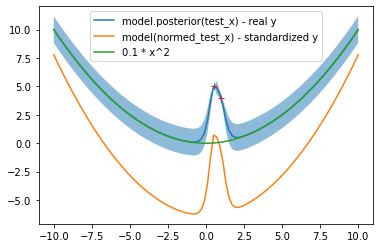

In [142]:
test_x = torch.linspace(-10,10,100).reshape(-1,1).unsqueeze(0)

with torch.no_grad():
    real_post = gp.posterior(test_x) # calling .posterior gives real (untransformed) output
    std_post = gp(transformer_x(test_x)) # calling gp gives standardized (transformed) output
    real_mean = real_post.mean
    std_mean = std_post.mean
    lower,upper = real_post.mvn.confidence_region()

fig,ax = plt.subplots()
ax.plot(test_x.flatten(), real_mean.flatten(), label = "model.posterior(test_x) - real y") # plot real y
ax.plot(test_x.flatten(), std_mean.flatten(), label = "model(normed_test_x) - standardized y") # plot standardized y
ax.plot(test_x.flatten(), 0.1 * test_x.flatten().pow(2), label = "0.1 * x^2") # plot prior mean
ax.plot(train_x, train_y, "+") # plot training samples

ax.fill_between(test_x.flatten(),lower.flatten(),upper.flatten(),alpha = 0.5)
ax.legend()